In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
from keras import backend as K
from keras.engine.topology import Layer

/Users/asmart5/python/nlp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, Concatenate, Flatten, Reshape
from keras.layers import Dense, Activation, Conv1D
from keras.optimizers import Adam
from keras import objectives

In [4]:
class ScaleNormalizer(Layer):
    def __init__(self, **kwargs):
        super(ScaleNormalizer, self).__init__(**kwargs)

    def build(self, inputShape):
        self.size = inputShape[1]
    
    def call(self, out_scale, mask=None):
        # softmax to normalize the scaling so this is a probability distribution 
        # these need to sum to 1, as they scale a guassian normal functions which have area 1
        max_scale = K.max(out_scale, axis=1, keepdims=True)
        out_scale = out_scale - max_scale
        out_scale = K.exp(out_scale)
        sum_scale = K.sum(out_scale, axis=1, keepdims=True)
        out_scale =  out_scale / sum_scale
        return out_scale
    
    def compute_output_shape(self, inputShape):
        return inputShape    
        
class MuNormalizer(Layer):
    def __init__(self, numComponents=None, outputDim=None, **kwargs):
        self.numComponents=numComponents
        self.outputDim=outputDim
        super(MuNormalizer, self).__init__(**kwargs)

    def build(self, inputShape):
        self.size = inputShape[1]
    
    def call(self, mu, mask=None):
        # means so whatever is ok
        return mu
    
    def compute_output_shape(self, inputShape):
        return inputShape

class SigmaNormalizer(Layer):
    def __init__(self, **kwargs):
        super(SigmaNormalizer, self).__init__(**kwargs)

    def build(self, inputShape):
        self.size = inputShape[1]
    
    def call(self, out_sigma, mask=None):
        # sigma *must* be positive, hit it with an expodential which is always >0
        # this will give it prior bias as well
        out_sigma = K.exp(out_sigma)
        return out_sigma
    
    def compute_output_shape(self, inputShape):
        return inputShape

In [5]:
class ProbabilityLayer(Layer):
    def calc_normal(self, x, scale, mu, sigma):
        const = 1 / math.sqrt(2*math.pi)
        var =  (1 / (sigma + 1e-8))
        
        result = x - mu
        result = result * var
        result = -K.square(result)/2
        result = K.exp(result) 
        result = result * scale * var * const

        return result
        
    def __init__(self, **kwargs):
        super(ProbabilityLayer, self).__init__(**kwargs)

    def build(self, inputShapes):
        pass

    def call(self, params, mask=None):
        target = params[0] 
        scale  = params[1] 
        mu     = params[2]
        sigma  = params[3]
        
        result = self.calc_normal(target, scale, mu, sigma)
        result = K.sum(result, axis=1, keepdims=True)
        
        return result
    
    def compute_output_shape(self, inputShapes):
        return (inputShapes[0][0], 1)

In [6]:
class TradeGenerator:
    def __init__(self, count=10000):
        self.count = count

        self.spike_rate = 0.80 + 0.2*np.random.uniform()
        self.cycle_rate = 0.80 + 0.2*np.random.uniform()
        self.trend_rate = 0.80 + 0.2*np.random.uniform()
        self.trend_scale = 4.0
        
        self.value = 100
        self.ema = self.value
        self.trend = self.trend_scale * np.random.uniform()
        
    def __iter__(self):
        while self.count > 0:
            self.count -= 1
        
            self.value += np.random.normal() + self.trend

            # spike
            if np.random.uniform() > self.spike_rate:
                self.value += (np.random.uniform() - 0.5)*0.3 * self.value

            # cycling
            ratio = 0.95
            self.ema = ratio * self.ema + (1.0 - ratio) * self.value            
            if np.random.uniform() > self.cycle_rate:
                self.trend = (self.ema - self.value) / (np.random.uniform() * 20 + 10)
            
            # re-trending
            if np.random.uniform() > self.trend_rate:
                # trend change
                self.trend = self.trend_scale * np.random.normal() 
                
            if self.value <= 0.0:
                self.value = 1.0

            yield(self.value)        

In [7]:
def generate(sampleSize   =600,
             samplePast   =20,
             samplesFuture=5):

    sampleLength = samplePast + samplesFuture
    
    trades_past  = []
    x            = []
    y            = []
    trades_future= []
    
    for i in range(sampleSize):
        seq = np.array([i for i in TradeGenerator(count=sampleLength)])

        # normalize data to "now" point
        seq = seq / seq[samplePast]

        for i in range(sampleLength):
            trades_past.append(seq[:samplePast])
            trades_future.append(seq[samplePast:])
            x     .append(i)
            y     .append(seq[i])   


            
    return np.array(trades_past), np.array(x), np.array(y), np.array(trades_future)

In [15]:
trades_past,x_data,y_data,trades_future = generate()

In [16]:
trades_past.shape, x_data.shape, y_data.shape,trades_future.shape

((15000, 20), (15000,), (15000,), (15000, 5))

In [10]:
target = np.ones((y_data.shape[0], 1))

In [17]:
def build_model(inputSize=20,         # prior trades
                convWindow=5,
                filterSize=3,
                embeddingSize=6,
                numComponents=24,
                outputDim=1):

    # using and auto encoder structure as i dont want memorizeation of inputs
    # TODO consider a UNET design 

    # network to "encode" trade info 
    i_trades = Input(shape=(inputSize,))

    x = Reshape((-1,1))(i_trades)
    x = Conv1D(3, 5)(x)
    x = Activation('relu')(x)
    x = Conv1D(3, 5)(x)
    x = Activation('relu')(x)
    x = Conv1D(3, 5)(x)
    x = Flatten()(x)
    x = Dense(embeddingSize)(x)

    # network to learn the mixture params 
    i_x = Input(shape=(1,))

    x = Concatenate()([x,i_x])
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(numComponents*3)(x)

    # now splice it up into the mixture params
    scale = Lambda(lambda x: x[:,:numComponents],                output_shape=(numComponents,))(x)
    mu    = Lambda(lambda x: x[:,numComponents:2*numComponents], output_shape=(numComponents,))(x)
    sigma = Lambda(lambda x: x[:,2*numComponents:],              output_shape=(numComponents,))(x)

    # correct the params into the right ranges/priors
    scale = ScaleNormalizer()(scale)
    mu    = MuNormalizer(numComponents=numComponents, outputDim=outputDim)(mu)
    sigma = SigmaNormalizer()(sigma)

    # give us an output tap on the params so we can get an idea of the sanity if needed
    # model_mix_settings = Model(inputs=[i_trades,i_x], outputs=[scale,mu,sigma])

    # now add the layers that computes probility out from the the mixture functions at the (x,y) point
    o_y = Input(shape=(1,))
    x = ProbabilityLayer()([o_y,scale,mu,sigma])

    model_train = Model(inputs=[i_trades,i_x,o_y], outputs=x)
    model_train.summary()

    opt = Adam(lr=0.001)
    model_train.compile(loss='binary_crossentropy',optimizer=opt)
    
    return model_train

In [18]:
model_train = build_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 20, 1)        0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 16, 3)        18          reshape_2[0][0]                  
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 16, 3)        0           conv1d_4[0][0]                   
__________________________________________________________________________________________________
conv1d_5 (

In [19]:
hist = model_train.fit([trades_past,x_data, y_data], target, batch_size=x_data.shape[0], epochs=1000, verbose=1)

Epoch 1/1000
15000/15000 [==============================] - 1s 62us/step - loss: 1.9751
Epoch 2/1000
15000/15000 [==============================] - 0s 14us/step - loss: 1.6493
Epoch 3/1000
15000/15000 [==============================] - 0s 12us/step - loss: 1.4664
Epoch 4/1000
15000/15000 [==============================] - 0s 11us/step - loss: 1.2284
Epoch 5/1000
15000/15000 [==============================] - 0s 13us/step - loss: 1.0702
Epoch 6/1000
15000/15000 [==============================] - 0s 14us/step - loss: 0.9223
Epoch 7/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.8564
Epoch 8/1000
15000/15000 [==============================] - 0s 13us/step - loss: 0.8225
Epoch 9/1000
15000/15000 [==============================] - 0s 15us/step - loss: 0.7632
Epoch 10/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.8374
Epoch 11/1000
15000/15000 [==============================] - 0s 12us/step - loss: 0.8621
Epoch 12/1000
15000/15000 [===

Epoch 94/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0599
Epoch 95/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0619
Epoch 96/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0620
Epoch 97/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0629
Epoch 98/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0622
Epoch 99/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0608
Epoch 100/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0599
Epoch 101/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0593
Epoch 102/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0584
Epoch 103/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0583
Epoch 104/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0580
Epoch 105/1000
1

15000/15000 [==============================] - 0s 11us/step - loss: 0.0415
Epoch 186/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0414
Epoch 187/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0414
Epoch 188/1000
15000/15000 [==============================] - 0s 12us/step - loss: 0.0414
Epoch 189/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0414
Epoch 190/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0412
Epoch 191/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0412
Epoch 192/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0410
Epoch 193/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0408
Epoch 194/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0405
Epoch 195/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0403
Epoch 196/1000
15000/1500

Epoch 277/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0322
Epoch 278/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0320
Epoch 279/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0317
Epoch 280/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0318
Epoch 281/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0319
Epoch 282/1000
15000/15000 [==============================] - 0s 12us/step - loss: 0.0321
Epoch 283/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0315
Epoch 284/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0322
Epoch 285/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0318
Epoch 286/1000
15000/15000 [==============================] - 0s 14us/step - loss: 0.0313
Epoch 287/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0330
Epoch 288/

15000/15000 [==============================] - 0s 11us/step - loss: 0.0481
Epoch 369/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0476
Epoch 370/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0529
Epoch 371/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0554
Epoch 372/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0552
Epoch 373/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0524
Epoch 374/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0477
Epoch 375/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0417
Epoch 376/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0422
Epoch 377/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0423
Epoch 378/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0408
Epoch 379/1000
15000/1500

Epoch 460/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0303
Epoch 461/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0302
Epoch 462/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0302
Epoch 463/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0298
Epoch 464/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0297
Epoch 465/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0297
Epoch 466/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0297
Epoch 467/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0297
Epoch 468/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0296
Epoch 469/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0294
Epoch 470/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0294
Epoch 471/

15000/15000 [==============================] - 0s 11us/step - loss: 0.0264
Epoch 552/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0265
Epoch 553/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0265
Epoch 554/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0264
Epoch 555/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0264
Epoch 556/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0263
Epoch 557/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0263
Epoch 558/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0263
Epoch 559/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0262
Epoch 560/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0262
Epoch 561/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0261
Epoch 562/1000
15000/1500

Epoch 643/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0246
Epoch 644/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0245
Epoch 645/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0245
Epoch 646/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0245
Epoch 647/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0245
Epoch 648/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0244
Epoch 649/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0245
Epoch 650/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0244
Epoch 651/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0245
Epoch 652/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0244
Epoch 653/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0244
Epoch 654/

Epoch 735/1000
15000/15000 [==============================] - 0s 12us/step - loss: 0.0234
Epoch 736/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0233
Epoch 737/1000
15000/15000 [==============================] - 0s 13us/step - loss: 0.0234
Epoch 738/1000
15000/15000 [==============================] - 0s 14us/step - loss: 0.0233
Epoch 739/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0232
Epoch 740/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0233
Epoch 741/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0232
Epoch 742/1000
15000/15000 [==============================] - 0s 13us/step - loss: 0.0233
Epoch 743/1000
15000/15000 [==============================] - 0s 12us/step - loss: 0.0234
Epoch 744/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0235
Epoch 745/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0236
Epoch 746/

15000/15000 [==============================] - 0s 11us/step - loss: 0.0223
Epoch 827/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0222
Epoch 828/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0223
Epoch 829/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0223
Epoch 830/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0222
Epoch 831/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0222
Epoch 832/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0223
Epoch 833/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0222
Epoch 834/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0221
Epoch 835/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0221
Epoch 836/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0221
Epoch 837/1000
15000/1500

Epoch 918/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0212
Epoch 919/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0214
Epoch 920/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0213
Epoch 921/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0212
Epoch 922/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0212
Epoch 923/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0212
Epoch 924/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0212
Epoch 925/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0211
Epoch 926/1000
15000/15000 [==============================] - 0s 10us/step - loss: 0.0211
Epoch 927/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0210
Epoch 928/1000
15000/15000 [==============================] - 0s 11us/step - loss: 0.0211
Epoch 929/

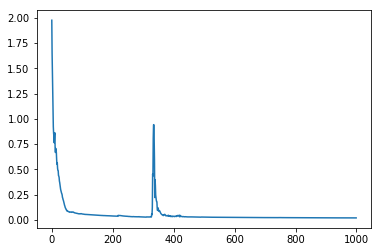

In [21]:
plt.plot(hist.history["loss"])

In [56]:
# TODO correct function params.. its using things not handed to it

def render(idx=0):# now select a trade sequance and rennder its predictionn space
    x = np.arange(0, 25.0, 0.5)
    y = np.arange(0.5, 2, 0.05)
    X, Y = np.meshgrid(x, y)

    past_selection = trades_past[idx:idx+1,:].flatten()
    past_x = np.arange(past_selection.shape[0])

    trade_input = np.repeat(past_selection.reshape((1,-1)), np.prod(X.shape), axis=0)
    future_selection   = trades_future[idx:idx+1,:].flatten()
    future_x = np.arange(future_selection.shape[0]) + past_selection.shape[0]

    Z = model_train.predict([trade_input, X.flatten().reshape((-1,1)), Y.flatten().reshape((-1,1))])
    Z = Z.reshape(X.shape)
    
    fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(20,7))
    
    im = ax1.pcolormesh(X,Y,Z,  cmap='YlGn')
    fig.colorbar(im, ax=ax1)
    ax1.contour(X, Y, Z)
    ax1.plot(past_x   , past_selection, "r")
    ax1.plot(future_x , future_selection, "r")
    
    logZ = np.log(Z)
    im = ax2.pcolormesh(X,Y,logZ,  cmap='YlGn')    
    fig.colorbar(im, ax=ax2)
    ax2.contour(X, Y, logZ)
    ax2.plot(past_x   , past_selection, "r")
    ax2.plot(future_x , future_selection, "r")
    plt.show()

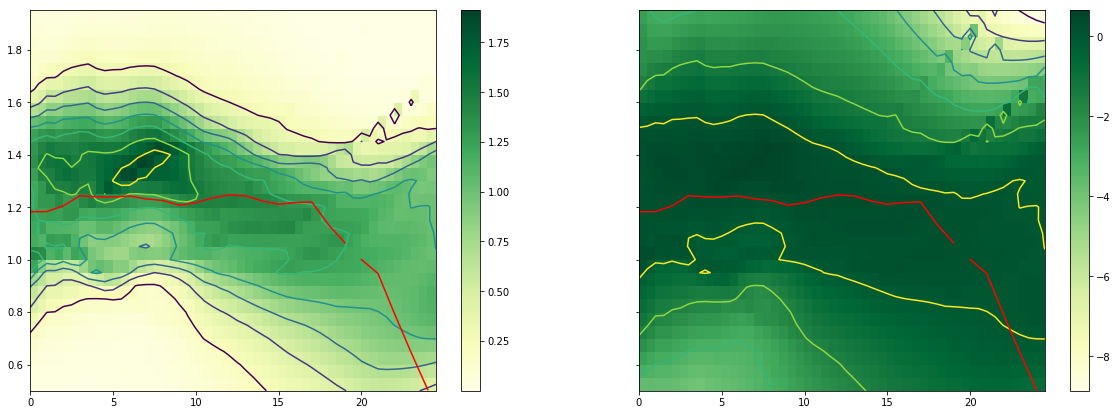

In [57]:
render(0)

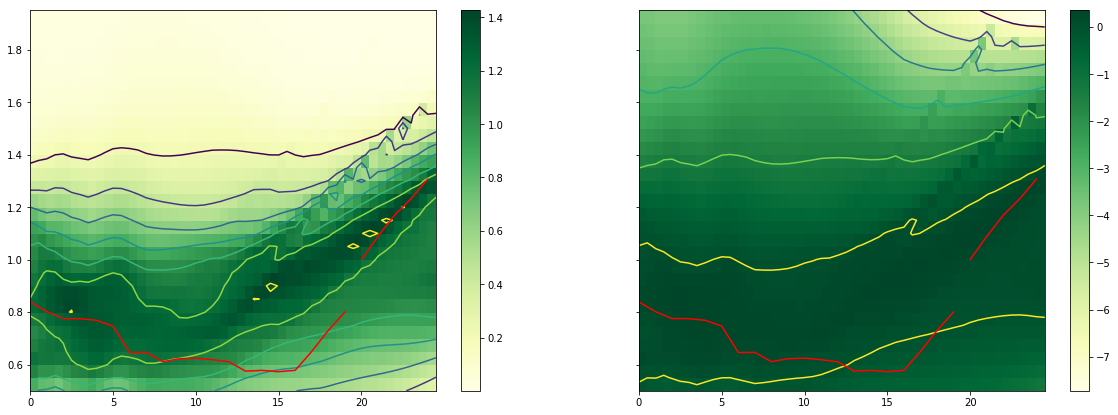

In [58]:
render(500)

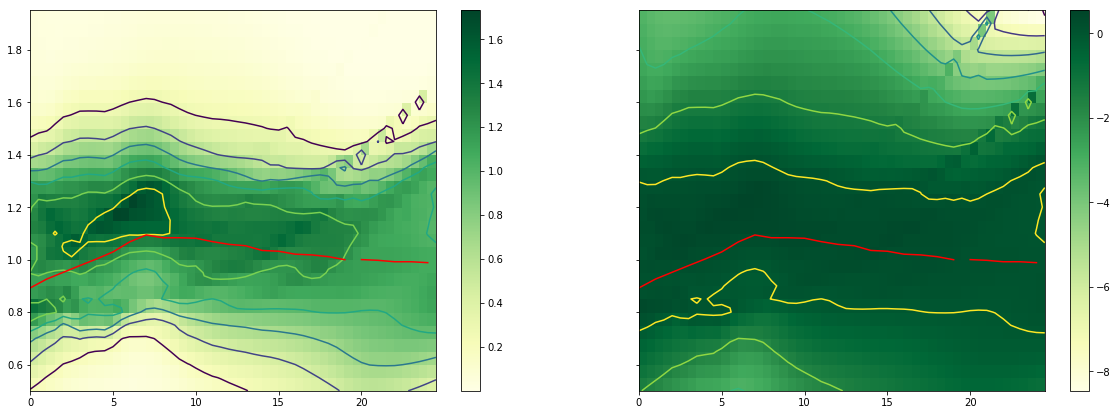

In [59]:
render(1000)